In [11]:
!pip install pandas numpy seaborn matplotlib scikit-learn xgboost lightgbm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 3.1 MB 9.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut

import warnings

warnings.filterwarnings('ignore')

In [53]:
! apt-get update
! apt-get install -y fonts-nanum
! fc-cache -fv
! rm -rf ~/.cache/matplotlib/*

Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 117 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped dir

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

In [3]:
%cd /workspace/

/workspace


## 음극 인장강도 Regression

In [20]:
# import excel file sheet

df = pd.read_excel('./data/230901/음극 인장강도 매칭.xlsx', sheet_name='data').loc[:14] # 원본 그대로 읽으면 불필요한 아래 시각화 정보까지 읽게 됨

# Data Pre-processing: Use data up to row 38
data_selected = df.copy()

# Define features and target 
features = data_selected.drop(columns=["File Name", "인장강도"])

target = data_selected["인장강도"]

In [ ]:
features.columns

Index(['g. NIR Peak_MEAN', 'a_1. LO height MEAN_MEAN',
       'a_1. LO height MEAN_STD', 'a_2. LO height MIN_MEAN',
       'a_2. LO height MIN_STD', 'a_3. LO height Peak_MEAN',
       'a_3. LO height Peak_STD', 'a_4. LO height STD_MEAN',
       'a_4. LO height STD_STD', 'b. LO FWHM_MEAN', 'b. LO FWHM_STD',
       'c. LO 면적_MEAN', 'c. LO 면적_STD', 'd. BR Peak_MEAN', 'd. BR Peak_STD',
       'e. BR Peak 시간_MEAN', 'e. BR Peak 시간_STD', 'f. NIR Time_MEAN',
       'f. NIR Time_STD', 'g. NIR Peak_MEAN.1', 'g. NIR Peak_STD',
       'h. 기준선 이상 NIR 신호 면적_MEAN', 'h. 기준선 이상 NIR 신호 면적_STD',
       'i_1. NIR 남은 신호 길이_MEAN', 'i_1. NIR 남은 신호 길이_STD',
       'i_2. NIR 남은 신호 면적_MEAN', 'i_2. NIR 남은 신호 면적_STD', 'j. 구간 면적_MEAN',
       'j. 구간 면적_STD', 'k. VIS Time_MEAN', 'k. VIS Time_STD',
       'm. VIS Peak_MEAN', 'm. VIS Peak_STD', 'n. 기준선 이상 VIS 신호 면적_MEAN',
       'n. 기준선 이상 VIS 신호 면적_STD', 'o_1. VIS 남은 신호 길이_MEAN',
       'o_1. VIS 남은 신호 길이_STD', 'o_2. VIS 남은 신호 면적_MEAN',
       'o_2. VIS 남은 신호 면적_STD

In [21]:
features.tail(5) #  마지막 시편 기록에서 s.BR9.5over_길이_MEAN의 값이 0을 기록하고 있는데, 결측치를 일괄 처리한 것인지 아니면 실제 feature가 0인지 확인 필요

,g. NIR Peak_MEAN,a_1. LO height MEAN_MEAN,a_1. LO height MEAN_STD,a_2. LO height MIN_MEAN,a_2. LO height MIN_STD,a_3. LO height Peak_MEAN,a_3. LO height Peak_STD,a_4. LO height STD_MEAN,a_4. LO height STD_STD,b. LO FWHM_MEAN,...,n. 기준선 이상 VIS 신호 면적_MEAN,n. 기준선 이상 VIS 신호 면적_STD,o_1. VIS 남은 신호 길이_MEAN,o_1. VIS 남은 신호 길이_STD,o_2. VIS 남은 신호 면적_MEAN,o_2. VIS 남은 신호 면적_STD,p. BR GAP (peak LO off)_MEAN,p. BR GAP (peak LO off)_STD,s.BR 9.5over_길이_MEAN,s.BR 9.5over_길이_STD
10,0.10002,47.72108,0.03536,42.96801,0.60389,48.54121,0.21656,0.62938,0.08849,1.96000,...,2.11093,0.68141,0.12296,0.15625,0.08145,0.33463,5.14910,1.61594,56.42593,14.68615
11,0.09114,47.72790,0.03652,42.55143,1.16584,48.53241,0.18248,0.62524,0.12053,1.96000,...,2.04237,0.47967,0.07074,0.13093,0.01283,0.00541,5.47369,1.70857,55.55556,13.82596
12,0.13004,53.82126,0.03977,48.33107,0.93752,54.65762,0.20877,0.76002,0.09559,1.96815,...,3.79934,0.61204,0.13296,0.11368,0.03830,0.02581,6.98026,0.75009,44.55556,11.03283
13,0.17521,53.84807,0.05421,49.93749,1.79172,54.60842,0.20425,0.50607,0.17634,1.96000,...,4.44401,2.26879,0.34222,0.21634,0.23672,0.66652,7.15795,0.78296,36.88889,10.82043
14,0.15624,53.80136,0.03752,48.35979,0.46567,54.59534,0.22256,0.67726,0.05184,1.95963,...,3.99329,0.96654,0.33667,0.21874,0.13142,0.34685,7.27080,0.64798,38.87037,10.56882


In [22]:
sum(features.isna().sum()>0) # 결측치 확인 -> 결측치 없음.

0

In [23]:
target.isna().sum() # 결측치 확인 -> 결측치 없음.

0

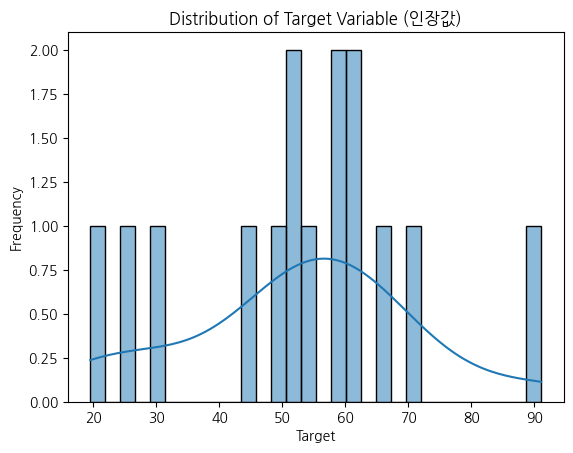

In [24]:
# EDA: Visualizations
# Histogram of the target variable
sns.histplot(target, bins=30, kde=True)
plt.title('Distribution of Target Variable (인장값)')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

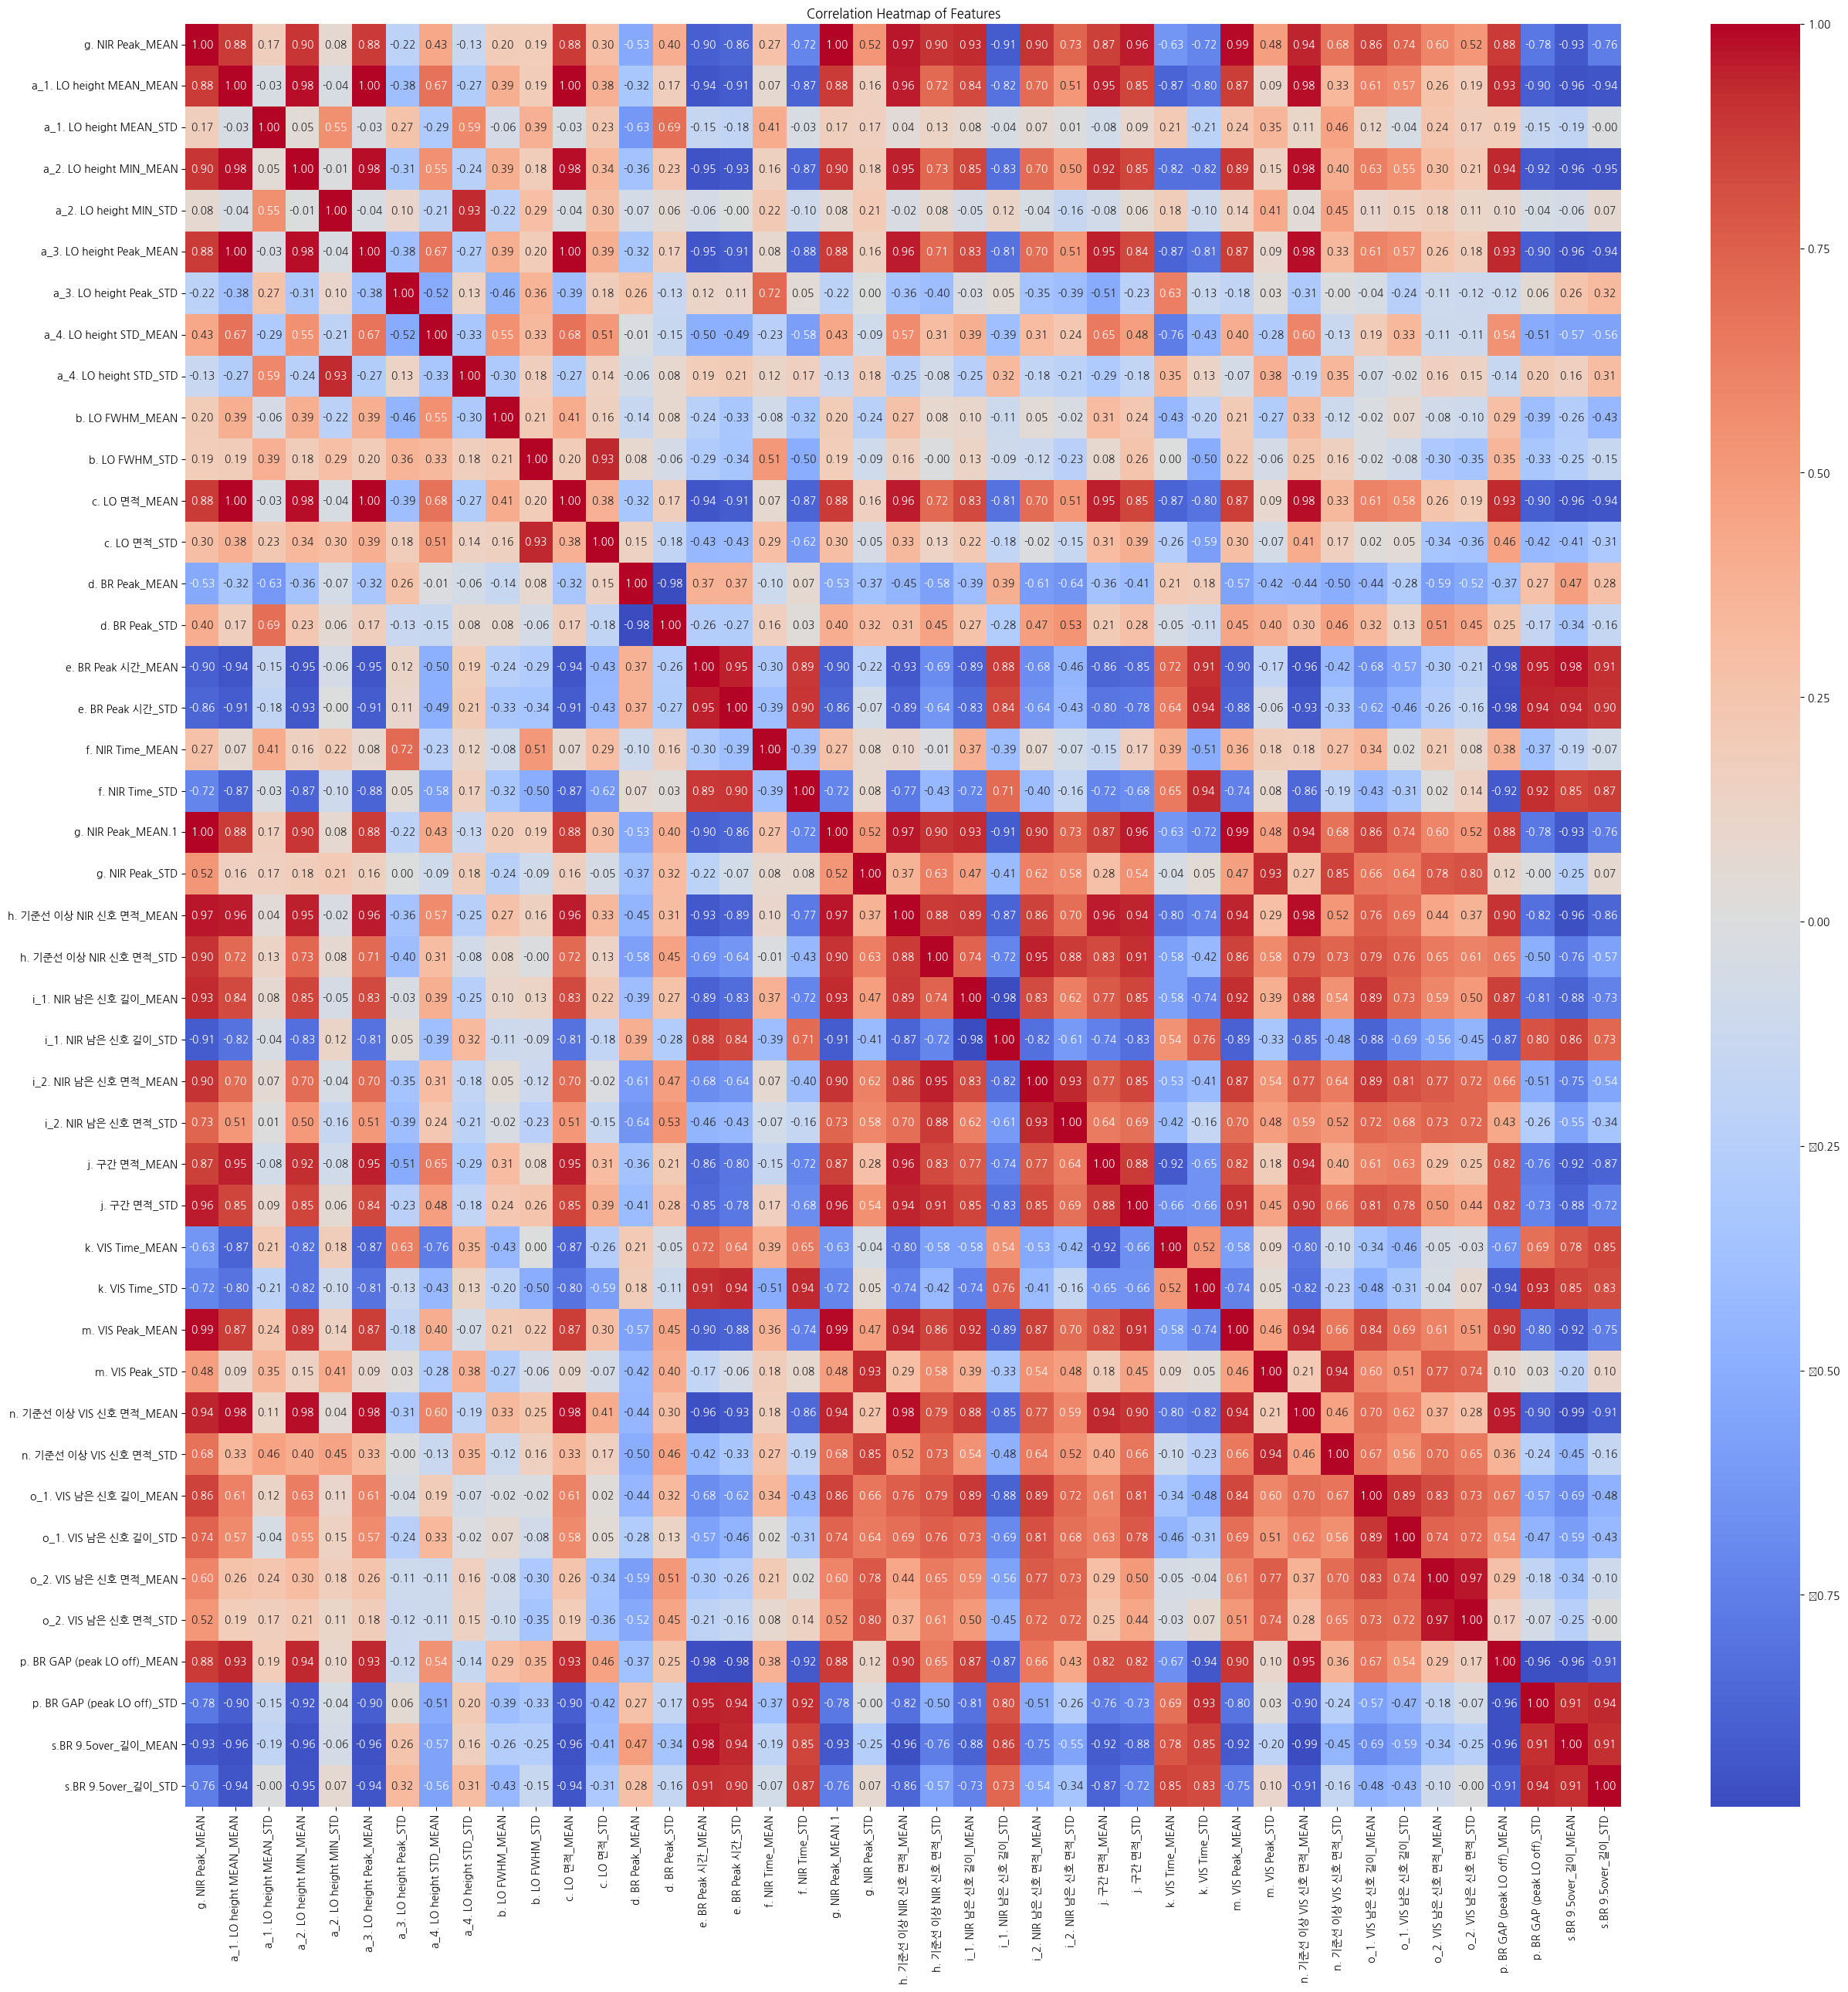

In [25]:
# Correlation heatmap of features 

plt.figure(figsize=(30, 30))
sns.heatmap(features.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

In [26]:
np.random.seed(42)

# Modeling with LOOCV
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective ='reg:squarederror', random_state=42,
                            tree_method='gpu_hist', 
                            gpu_id=0,
                            ),
    'LightGBM': LGBMRegressor(
                        min_data_in_leaf=1, 
                        min_split_gain=0.0, 
                        num_leaves=31, 
                        max_depth=-1,
                        lambda_l1=0.0,
                        lambda_l2=0.0,
                        learning_rate=0.05,
                        n_estimators=500,
                        random_state=42,
                        device='cpu',
                        verbose=-1
                        )
}

loocv = LeaveOneOut()

results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE'])

In [29]:
from collections import defaultdict
from tqdm import tqdm
feat_import = defaultdict(list)
 
for model_name, model in models.items():

    predictions = []
    actuals = []
    
    for train_index, test_index in tqdm(loocv.split(features)):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)[0]
        
        predictions.append(prediction)
        actuals.append(y_test.iloc[0])
    
    try:
        # Extract feature importances
        importances = model.feature_importances_
        
        # Create a DataFrame for visualization
        feature_importances = pd.DataFrame({
            'Feature': features.columns,
            'Importance': importances
        })
        
        # Sort features according to importance
        feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

        feat_import[model_name] = feature_importances

    except AttributeError:
        print(f"{model_name} does not support feature_importances_")

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    
    results = results.append({
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse
    }, ignore_index=True)

    print(f"{model_name} - MSE: {mse:.2f}, RMSE: {rmse:.2f}")

15it [00:00, 241.26it/s]


Linear Regression does not support feature_importances_
Linear Regression - MSE: 38.36, RMSE: 6.19


15it [00:00, 300.39it/s]


Ridge Regression does not support feature_importances_
Ridge Regression - MSE: 70.00, RMSE: 8.37


15it [00:00, 225.91it/s]


Lasso Regression does not support feature_importances_
Lasso Regression - MSE: 73.04, RMSE: 8.55


15it [00:00, 37.93it/s]


Gradient Boosting - MSE: 126.98, RMSE: 11.27


15it [00:01, 11.68it/s]


XGBoost - MSE: 190.46, RMSE: 13.80


15it [00:01, 11.53it/s]

LightGBM - MSE: 243.86, RMSE: 15.62


In [30]:
results # 변수간 상관관계가 태생적으로 높기 때문에 다중공산성으로 인해 Linear Regression, Ridge, Lasso의 성능이 좋지 않음. PCA를 통해 상관관계를 제거한 뒤에 PC를 사용하여 모델링을 하는 것도 고려할 수 있음

,Model,MSE,RMSE
0,Linear Regression,38.361468,6.193664
1,Ridge Regression,69.995793,8.366349
2,Lasso Regression,73.043923,8.546574
3,Gradient Boosting,126.975229,11.268329
4,XGBoost,190.462472,13.800814
5,LightGBM,243.861846,15.616077


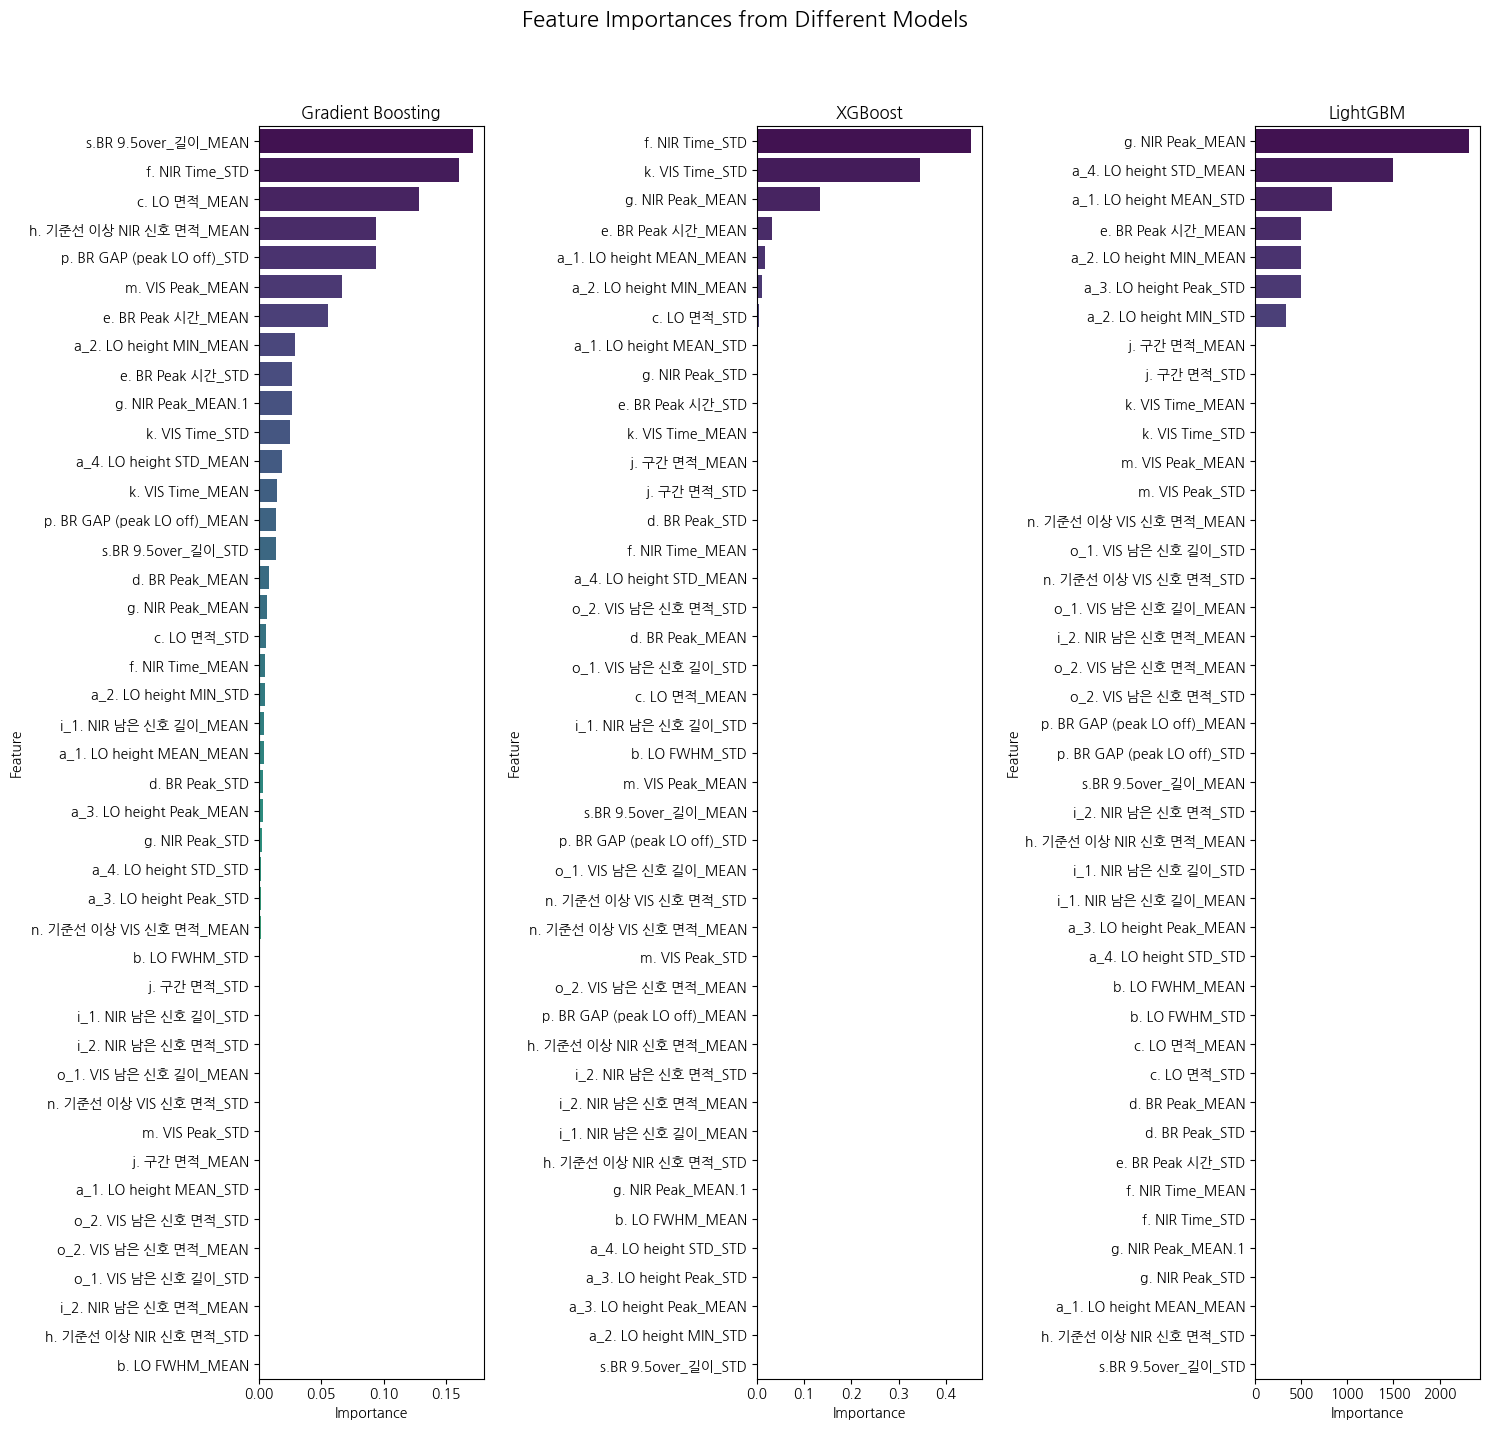

In [31]:
model_import = ['Gradient Boosting', 'XGBoost', 'LightGBM']

# Set up the matplotlib figure
num_models = len(model_import)
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(15, 15))
fig.suptitle('Feature Importances from Different Models', fontsize=16)

# Plotting
for ax, model_name in zip(axes, model_import):

    feature_importances = feat_import[model_name]
    
    # Plot
    sns.barplot(x='Importance', y='Feature', data=feature_importances, ax=ax, palette='viridis')
    ax.set_title(model_name)
    ax.set_xlabel('Importance')
    
axes[0].set_ylabel('Feature')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the padding between and around subplots
plt.show()